In [1]:
# Import TfidfVectorizer for text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Import PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Import pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Import SelectKBest and mutual_info_classif for feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# Import train_test_split for splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# Import RandomUnderSampler for undersampling imbalanced data
from imblearn.under_sampling import RandomUnderSampler

# Import tqdm for progress bars
from tqdm.notebook import tqdm

# Import deepcopy for copying objects
from copy import deepcopy

# Import zip_longest for iterating over multiple iterables of different lengths
from itertools import zip_longest

# Import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sb

# Set seaborn theme
sb.set_theme()

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
class Preprocessing:
    def __init__(self, data) -> None:
        self.data = data

    def _process_data(self):
        """
        convert data into a pandas dataframe
        """
        data_arr = []

        data_records = self.data.split("\n")[:-1]
        for data in data_records:
            label = None
            sample = None
            match data[:3]:
                case "ham":
                    label = "legitimate"
                    sample = data[4:]
                case "spa":
                    label = "spam"
                    sample = data[5:]
                case _:
                    label = "N/A"

            data_arr.append([label, sample])

        data_arr = np.array(data_arr)
        data_label = data_arr[:, 0]
        data_records = data_arr[:, 1]

        return data_records, data_label

    def tfidf_vectorizer(self, records):
        vectorizer = TfidfVectorizer(
            lowercase=True, token_pattern=r"\b[A-Za-z]+\b", norm=None
        )

        records_transformed = vectorizer.fit_transform(records)

        return records_transformed.toarray(), vectorizer.get_feature_names_out()

    def feature_extraction(self, X, n_components=5):
        reduction_pca = PCA(n_components=n_components, whiten=False)
        data_reduced = reduction_pca.fit_transform(X)
        return data_reduced

    def feature_selection(self, df_records, labels, n_components=5):
        feature_selection_model = SelectKBest(mutual_info_classif, k=n_components)
        # make a selection over the best features
        selected_record_features = feature_selection_model.fit_transform(
            df_records, labels
        )

        return selected_record_features, feature_selection_model.get_feature_names_out()

    def random_under_sampling(self, df_records, labels):
        ros = RandomUnderSampler(random_state=18)
        X_resampled, y_resampled = ros.fit_resample(df_records, labels)
        return X_resampled, y_resampled

    def fit_transform(self):
        records, labels = self._process_data()
        records_vectorized, feature_names = self.tfidf_vectorizer(records)

        # one hot encoding labels
        labels = np.array([0 if y == "legitimate" else 1 for y in labels])

        # reducing dimension
        records_dim_reduced = self.feature_extraction(records_vectorized)
        records_vectorized = pd.DataFrame(records_vectorized, columns=feature_names)

        records_selection, feature_name_selection = self.feature_selection(
            records_vectorized, labels=labels
        )

        records_selection, labels = self.random_under_sampling(
            records_selection, labels
        )

        return (
            pd.DataFrame(records_selection, columns=feature_name_selection),
            pd.DataFrame(records_dim_reduced, columns=[1, 2, 3, 4, 5]),
            labels,
        )

In [3]:
# Initialize variable to store data from file
sms_data_str = None

# Open the file in read mode
with open("SMSSpamCollection") as f:
    # Read the contents of the file and store it in the variable
    sms_data_str = f.read()

In [4]:
# Create an instance of the Preprocessing class with the data from the file
preprocessing = Preprocessing(sms_data_str)

# Call the fit_transform method to preprocess the data
records_selection, records_dim_reduced, labels = preprocessing.fit_transform()

# Split the preprocessed data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    records_selection, labels, test_size=0.2, random_state=24
)

In [5]:
class Chromosome:
    # Define constants for linguistic terms and functions
    LINGUISTIC_TERMS = ["Normal", "Minor", "Moderate", "Serious", "Severe"]
    FUNCTIONS = ["iso-tri", "rect-trap", "gaussian", "sigmoid"]

    def __init__(self) -> None:
        self.variables = None
        self.terms_per_variable = None
        self.is_not = None
        self.cls = None
        self.linguistic_model = {}
        self.fitness = None

    def __repr__(self) -> str:
        # Define a string representation of the chromosome
        s = ""
        tmp = []
        for variable in self.variables:
            tmp.append(
                f"{variable} is {'not ' if self.is_not[variable] else ''}{self.terms_per_variable[variable]}"
            )
        s += " and ".join(tmp)
        s += f" then {self.cls}\n"
        s += f"Fitness: {self.fitness}\n"
        s += "---------------------------------------\n"
        for key, value in self.linguistic_model.items():
            s += f"Variable: {key[0]} - Term: {key[1]} - Function: {value[0]} - Param m: {value[1]} - Param s: {value[2]}\n"
        return s

    def initialize(self):
        # Initialize the chromosome with random values
        self.variables = np.random.choice(
            x_train.columns.to_numpy(),
            size=(np.random.randint(1, 5)),
            replace=False,
        )

        self.terms_per_variable = {
            variable: np.random.choice(Chromosome.LINGUISTIC_TERMS)
            for variable in self.variables
        }

        self.is_not = {
            variable: np.random.choice([True, False]) for variable in self.variables
        }

        self.cls = np.random.choice([0, 1])

        for var in self.variables:
            func = np.random.choice(Chromosome.FUNCTIONS)
            param_m = np.random.normal(-100, 100)
            param_s = np.random.normal(-100, 100)
            self.linguistic_model[(var, self.terms_per_variable[var])] = (
                func,
                param_m,
                param_s,
            )

    def calculate_fitness(self):
        f_class = 0
        f_neg_class = 0

        # Iterate over each row in the training data and compute its gR value
        for idx, row in x_train.reset_index().iterrows():
            gR = self._compute_gR(row)

            # Update the f_class and f_neg_class values based on the class of the row
            if y_train[idx] == self.cls:
                f_class += gR
            else:
                f_neg_class += gR

        # Compute the fitness of the chromosome
        if (f_class == 0) and (f_neg_class == 0):
            self.fitness = 0
        else:
            self.fitness = (f_class - f_neg_class) / (f_class + f_neg_class)

    def _compute_gR(self, x):
        # Compute the gR value for a given row of data
        gR = []

        for var in self.variables:
            # Get the function and parameters for the variable from the linguistic model
            fms = self.linguistic_model[(var, self.terms_per_variable[var])]
            function = fms[0]
            m, s = fms[1], fms[2]

            # Compute the value of the function for the variable
            if function == "iso-tri":
                val = np.max([0, np.min([(x[var] - m + s) / s, (m - x[var] + s) / s])])
            elif function == "rect-trap":
                val = np.max([0, np.min([(x[var] - m + s) / s, 1])])
            elif function == "gaussian":
                val = np.exp(-0.5 * (((x[var] - m) / s) ** 2))
            elif function == "sigmoid":
                val = 1 / (1 + np.exp(-((x[var] - m) / s)))

            # Negate the value if necessary
            gR.append(1 - val if self.is_not[var] else val)

        # Return the minimum gR value
        return np.min(gR)

    def mutate(self):
        # Get the current values of the m and s parameters from the linguistic model
        ms = [i[1] for k, i in self.linguistic_model.items()]
        ss = [i[2] for k, i in self.linguistic_model.items()]

        # Mutate the variables with a 50% probability
        for j in range(len(self.variables)):
            if np.random.random() <= 0.5:
                # Get the set of available variables that are not already in the chromosome
                arr = np.setdiff1d(x_train.columns.to_numpy(), self.variables)
                if arr.size:
                    # Remove the current variable and its associated values from the chromosome
                    tmp_tpv = self.terms_per_variable.pop(self.variables[j])
                    tmp_is_not = self.is_not.pop(self.variables[j])
                    # Replace the variable with a randomly selected available variable
                    self.variables[j] = np.random.choice(arr)
                    # Add the new variable and its associated values to the chromosome
                    self.terms_per_variable[self.variables[j]] = tmp_tpv
                    self.is_not[self.variables[j]] = tmp_is_not

        # Mutate the terms per variable with a 50% probability
        for k in self.terms_per_variable.keys():
            if np.random.random() <= 0.5:
                self.terms_per_variable[k] = np.random.choice(
                    Chromosome.LINGUISTIC_TERMS
                )

        # Mutate the is_not values with a 50% probability
        for k in self.is_not.keys():
            if np.random.random() <= 0.5:
                self.is_not[k] = np.random.choice([True, False])

        # Mutate the class with a 50% probability
        if np.random.random() <= 0.5:
            self.cls = np.random.choice([0, 1])

        # Clear the linguistic model and reinitialize it with new random values
        self.linguistic_model.clear()
        for var in self.variables:
            func = np.random.choice(Chromosome.FUNCTIONS)
            param_m = np.random.normal(np.mean(ms), np.std(ms))
            param_s = np.random.normal(np.mean(ss), np.std(ss))
            self.linguistic_model[(var, self.terms_per_variable[var])] = (
                func,
                param_m,
                param_s,
            )

    @staticmethod
    def recombinate(parent_1, parent_2):
        offspring1, offspring2 = Chromosome(), Chromosome()

        # Get the union of the variables from both parents
        parents_variables = np.union1d(parent_1.variables, parent_2.variables)

        # Initialize lists to store the values from both parents
        parents_terms_per_variable = []
        parents_is_not = []
        parents_linguistic_model = []

        for _, v in parent_1.terms_per_variable.items():
            parents_terms_per_variable.append(v)

        for _, v in parent_2.terms_per_variable.items():
            parents_terms_per_variable.append(v)

        for _, v in parent_1.is_not.items():
            parents_is_not.append(v)

        for _, v in parent_2.is_not.items():
            parents_is_not.append(v)

        for _, v in parent_1.linguistic_model.items():
            parents_linguistic_model.append(v)

        for _, v in parent_2.linguistic_model.items():
            parents_linguistic_model.append(v)

        # Initialize the values of the offspring chromosomes by randomly selecting from the union of the parent values
        offspring1.variables = np.random.choice(
            parents_variables, size=len(parent_1.variables), replace=False
        )
        offspring2.variables = np.random.choice(
            parents_variables, size=len(parent_2.variables), replace=False
        )

        offspring1.terms_per_variable = dict(
            zip(
                offspring1.variables,
                np.random.choice(
                    parents_terms_per_variable, size=len(offspring1.variables)
                ),
            )
        )

        offspring2.terms_per_variable = dict(
            zip(
                offspring2.variables,
                np.random.choice(
                    parents_terms_per_variable, size=len(offspring2.variables)
                ),
            )
        )

        offspring1.is_not = dict(
            zip(
                offspring1.variables,
                np.random.choice(parents_is_not, size=len(offspring1.variables)),
            )
        )

        offspring2.is_not = dict(
            zip(
                offspring2.variables,
                np.random.choice(parents_is_not, size=len(offspring2.variables)),
            )
        )

        offspring1.cls = np.random.choice([parent_1.cls, parent_2.cls])
        offspring2.cls = np.random.choice([parent_1.cls, parent_2.cls])

        for var in offspring1.variables:
            offspring1.linguistic_model[
                (var, offspring1.terms_per_variable[var])
            ] = parents_linguistic_model[
                np.random.randint(0, len(parents_linguistic_model))
            ]

        for var in offspring2.variables:
            offspring2.linguistic_model[
                (var, offspring2.terms_per_variable[var])
            ] = parents_linguistic_model[
                np.random.randint(0, len(parents_linguistic_model))
            ]

        return offspring1, offspring2

In [6]:
class Evolutionary_Algorithm:
    def __init__(
        self, population_size=100, max_generation=20, p_mutation=0.9, p_crossover=0.1
    ):
        self.population_size = population_size
        self.max_generation = max_generation
        self.p_mutation = p_mutation
        self.p_crossover = p_crossover
        self.population = []
        self.offsprings = []
        self.fitness_history = []

    def initialize(self):
        # Clears the population list and initializes it with new chromosomes
        self.population.clear()

        for __ in tqdm(
            range(self.population_size), colour="black", desc="Initializing"
        ):
            chromosome = Chromosome()
            chromosome.initialize()
            chromosome.calculate_fitness()
            self.population.append(chromosome)

    def mutation(self):
        # Mutates the offsprings with a probability of p_mutation
        for chromosome in self.offsprings:
            p_m = np.random.random()
            if p_m <= self.p_mutation:
                chromosome.mutate()

    def recombination(self, p1, p2):
        # Recombines two parents with a probability of p_crossover
        if np.random.random() <= self.p_crossover:
            offspring_1, offspring_2 = Chromosome.recombinate(p1, p2)
            self.offsprings.append(offspring_1)
            self.offsprings.append(offspring_2)
        # If the parents are not recombined, they are added to the offsprings list
        else:
            self.offsprings.append(deepcopy(p1))
            self.offsprings.append(deepcopy(p2))

    def tournament_selection(self):
        # Perform tournament selection on the population
        # Randomly select a subset of the population for the tournament
        tournament = np.random.choice(
            self.population, self.population_size // 2, replace=True
        )

        # Return the chromosome with the highest fitness from the tournament
        return max(tournament, key=lambda x: x.fitness)

    def mean_fitness(self):
        # Calculate the mean fitness of the population
        return np.mean([ch.fitness for ch in self.population])

    def generate_next_generation(self):
        # Generate the next generation of the population
        # Clear the list of offspring chromosomes
        self.offsprings.clear()

        # Perform recombination to create new offspring chromosomes
        for __ in range(self.population_size // 2):
            parent1 = self.tournament_selection()
            parent2 = self.tournament_selection()
            self.recombination(parent1, parent2)

        # Perform mutation on the offspring chromosomes
        self.mutation()

        # Calculate the fitness of the offspring chromosomes
        for ch in self.offsprings:
            ch.calculate_fitness()

        # Add the offspring chromosomes to the population
        self.population.extend(self.offsprings)

        # Sort the population by class and fitness
        pop_0 = sorted(
            [ch for ch in self.population if ch.cls == 0],
            key=lambda x: x.fitness,
            reverse=True,
        )
        pop_1 = sorted(
            [ch for ch in self.population if ch.cls == 1],
            key=lambda x: x.fitness,
            reverse=True,
        )

        # Interleave the two sorted populations and truncate to the population size
        tmp_ls = []
        for i in zip_longest(pop_0, pop_1):
            if i[0] is not None:
                tmp_ls.append(i[0])
            if i[1] is not None:
                tmp_ls.append(i[1])

        self.population = deepcopy(tmp_ls[: self.population_size])

    def run(self, verbose=True):
        # Run the evolutionary algorithm
        # Initialize the population
        self.initialize()

        # Iterate over each generation
        for i in tqdm(
            range(self.max_generation), desc="Running Evolutionary Algorithm"
        ):
            # Generate the next generation of the population
            self.generate_next_generation()
            # Record the mean fitness of the population
            self.fitness_history.append(self.mean_fitness())
            # Print progress information if verbose is True
            if verbose:
                print(f"Generation: {i+1}, Mean Fitness: {self.fitness_history[-1]}")
                print(
                    "------------------------------------------------------------------------------"
                )

            # Check if the mean fitness has not changed for 5 generations and stop early if it has not
            if len(self.fitness_history) > 5:
                last = self.fitness_history[-1]
                res = next(
                    i for i, j in enumerate(self.fitness_history[::-1]) if j != last
                )

                if res >= 5:
                    self.max_generation = i + 1
                    break

In [7]:
POPULATION_SIZE = 100
MAX_GENERATION = 50

ea = Evolutionary_Algorithm(
    population_size=POPULATION_SIZE,
    max_generation=MAX_GENERATION,
    p_mutation=0.9,
    p_crossover=0.9,
)
ea.run(verbose=True)

Initializing:   0%|          | 0/100 [00:00<?, ?it/s]

Running Evolutionary Algorithm:   0%|          | 0/50 [00:00<?, ?it/s]

Generation: 1, Mean Fitness: 0.025320448674076478
------------------------------------------------------------------------------
Generation: 2, Mean Fitness: 0.06696373165884813
------------------------------------------------------------------------------
Generation: 3, Mean Fitness: 0.09480641536242164
------------------------------------------------------------------------------
Generation: 4, Mean Fitness: 0.13730410109387964
------------------------------------------------------------------------------
Generation: 5, Mean Fitness: 0.16383998793556415
------------------------------------------------------------------------------
Generation: 6, Mean Fitness: 0.17117210565680283
------------------------------------------------------------------------------
Generation: 7, Mean Fitness: 0.17194518188767038
------------------------------------------------------------------------------
Generation: 8, Mean Fitness: 0.172790781228692
--------------------------------------------------------

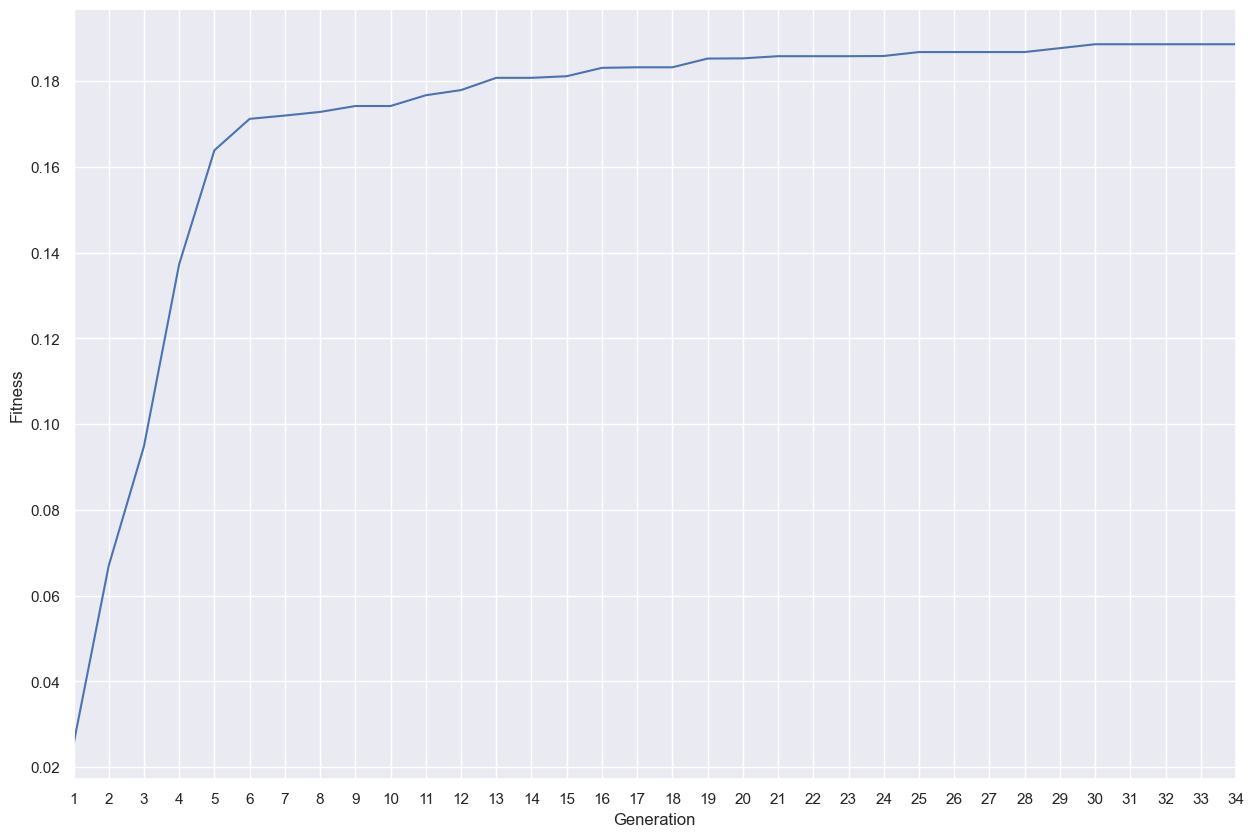

In [8]:
x_range = range(1, ea.max_generation + 1)
y = ea.fitness_history

# Create a new figure and axis object and Plot the fitness values over generations
plt.figure(figsize=(15, 10))
plt.plot(x_range, y)
plt.xticks(x_range)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.gca().xaxis.set_major_locator(MultipleLocator(1))
plt.xlim([1, ea.max_generation])
plt.savefig("fe_plot.png")
plt.show()

In [9]:
mutation = 0.9
recombination = 0.9
population_size = 100
generation = 50

# Open a file to write the linguistic model to
with open(
    f"linguistic_model_{mutation}_{recombination}_{population_size}_{generation}_featureSelection.txt",
    "w",
) as f:
    for num, rule in enumerate(ea.population, start=1):
        f.write(f"Rule {num}: {rule}\n")

In [10]:
def predict(population, data):
    # Predict the class of a given data point using the population of chromosomes
    gC_0 = 0
    gC_1 = 0

    # Iterate over each chromosome in the population
    for chromosome in population:
        # Compute the gR value for the data point using the chromosome
        if chromosome.cls == 0:
            gC_0 += chromosome._compute_gR(data)
        elif chromosome.cls == 1:
            gC_1 += chromosome._compute_gR(data)

    # Return the class with the highest gC value
    return np.argmax([gC_0, gC_1])

In [11]:
# Initialize lists to store the predicted and true labels
pred_label = []
true_label = []

# Iterate over each row in the test data
for idx, row in x_test.reset_index().iterrows():
    # Predict the class of the row using the population of chromosomes
    pred_label.append(predict(ea.population, row))
    # Add the true label of the row to the list
    true_label.append(y_test[idx])

# Compute and print the accuracy and F1 score of the predictions
print(accuracy_score(true_label, pred_label))
print(f1_score(true_label, pred_label))

0.6889632107023411
0.5714285714285715


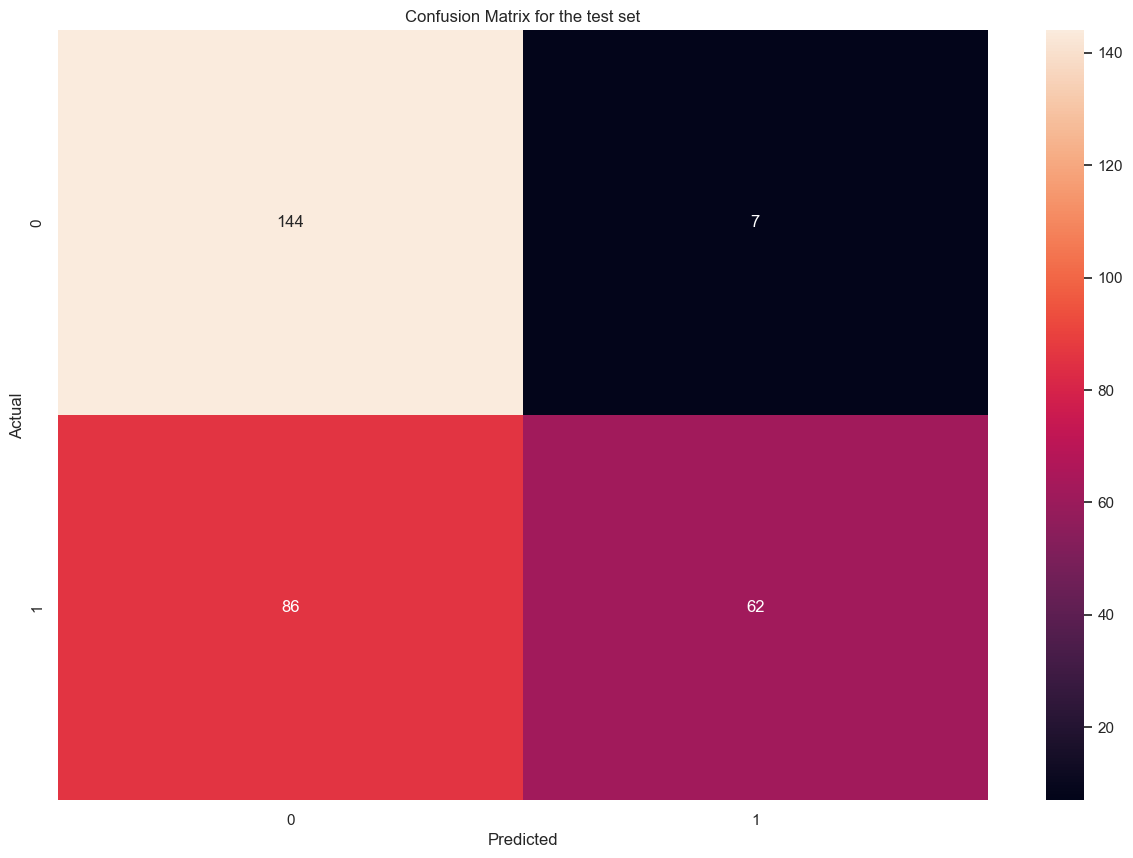

In [12]:
# Calculate the confusion matrix
cm_train = confusion_matrix(true_label, pred_label)
plt.subplots(figsize=(15, 10))
sb.heatmap(cm_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the test set")
plt.savefig("confusion_matrix_test.png")
plt.show()

In [13]:
# Initialize lists to store the predicted and true labels for the training data
pred_label_tr = []
true_label_tr = []

# Iterate over each row in the training data
for idx, row in x_train.reset_index().iterrows():
    # Predict the class of the row using the population of chromosomes
    pred_label_tr.append(predict(ea.population, row))
    # Add the true label of the row to the list
    true_label_tr.append(y_train[idx])

# Compute and print the accuracy and F1 score of the predictions on the training data
print(accuracy_score(true_label_tr, pred_label_tr))
print(f1_score(true_label_tr, pred_label_tr))

0.700418410041841
0.597752808988764


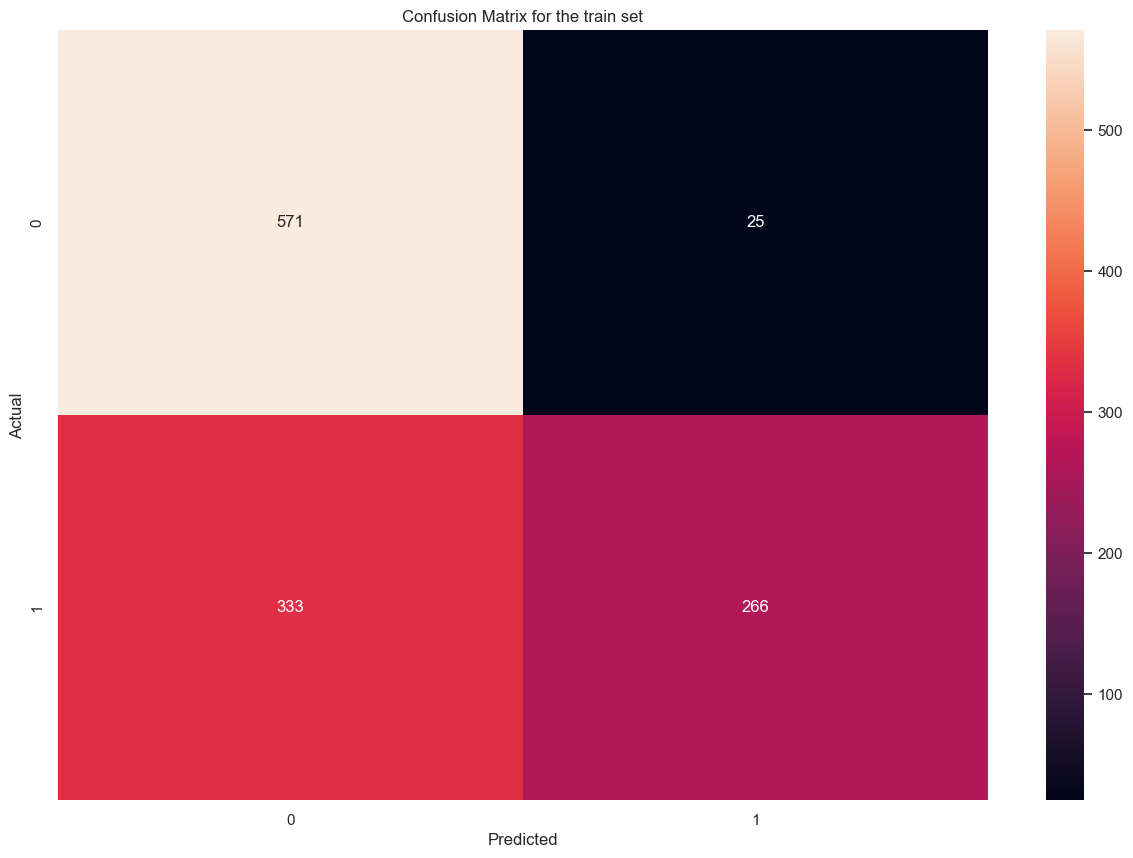

In [14]:
# Calculate the confusion matrix
cm_train = confusion_matrix(true_label_tr, pred_label_tr)
plt.subplots(figsize=(15, 10))
sb.heatmap(cm_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the train set")
plt.savefig("confusion_matrix_train.png")
plt.show()